Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import math

from sklearn import preprocessing
import datetime

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB5, preprocess_input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

from sklearn.model_selection import train_test_split

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

strategy = tf.distribute.MirroredStrategy(["GPU:0"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [3]:
df = pd.read_csv('Label_Training.csv')
df

,video_num,filename,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/246...
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/094...
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/158...
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/062...
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/174...
...,...,...,...,...,...,...
7015,35,177.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/17...
7016,35,066.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/06...
7017,35,042.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/04...
7018,35,250.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/25...


In [4]:
test = df[(df['patient']==1)]
test

,video_num,filename,infection,patient,class_label,image_path
0,1,246.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/246...
1,1,094.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/094...
2,1,158.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/158...
3,1,062.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/062...
4,1,174.tif,ca,1,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/1/174...
...,...,...,...,...,...,...
775,3,177.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/3/177...
776,3,066.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/3/066...
777,3,042.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/3/042...
778,3,250.tif,mock,1,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/3/250...


In [5]:
Xtrain = pd.concat([df, test]).drop_duplicates(keep=False)
Xtrain

,video_num,filename,infection,patient,class_label,image_path
780,4,246.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/246...
781,4,094.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/094...
782,4,158.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/158...
783,4,062.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/062...
784,4,174.tif,ca,2,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/4/174...
...,...,...,...,...,...,...
7015,35,177.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/17...
7016,35,066.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/06...
7017,35,042.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/04...
7018,35,250.tif,mock,12,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/35/25...


In [6]:
train, val = train_test_split(Xtrain, test_size=0.2, stratify = Xtrain['class_label'], random_state=42)
train

,video_num,filename,infection,patient,class_label,image_path
1322,6,186.tif,mock,2,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/6/186...
3459,22,178.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/22/17...
3528,22,107.tif,cg,8,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/22/10...
1668,13,142.tif,ca,5,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/13/14...
4519,26,197.tif,mock,9,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/26/19...
...,...,...,...,...,...,...
3011,20,140.tif,mock,7,2,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/20/14...
1682,13,189.tif,ca,5,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/13/18...
6588,34,115.tif,cg,12,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/34/11...
4264,25,179.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/25/17...


In [7]:
val

,video_num,filename,infection,patient,class_label,image_path
5852,31,069.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/31/06...
6462,33,056.tif,ca,12,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/33/05...
2053,14,233.tif,cg,5,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/14/23...
3211,21,051.tif,ca,8,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/21/05...
1706,13,039.tif,ca,5,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/13/03...
...,...,...,...,...,...,...
3924,24,098.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/24/09...
5908,31,103.tif,cg,11,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/31/10...
4352,25,072.tif,cg,9,1,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/25/07...
3929,24,161.tif,ca,9,0,/asbdata/Arjun/Bloodi/TIFF8_preprocessed/24/16...


In [8]:
image_size = 512
batch_size = 16

def get_train_generator(df, x_col, y_cols, shuffle=True, batch_size=batch_size, seed=1, image_size=image_size):

    # normalize images
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size=(image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, x_col, y_cols, batch_size=batch_size, seed=1, image_size=image_size):

    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)


    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=None,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            target_size = (image_size,image_size),
            shuffle=False,
            seed=seed)
    
    return valid_generator, test_generator

In [9]:
train_generator = get_train_generator(train, 'image_path', 'class_label')
valid_generator, test_generator= get_test_and_valid_generator(val, test, 'image_path','class_label')

Found 4992 validated image filenames.
Found 1248 validated image filenames.
Found 780 validated image filenames.


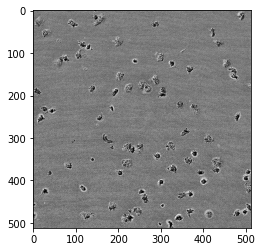

In [10]:
x, y = train_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

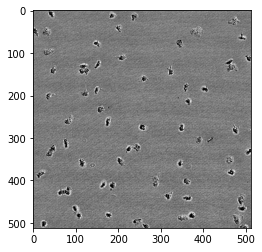

In [11]:
x, y = valid_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

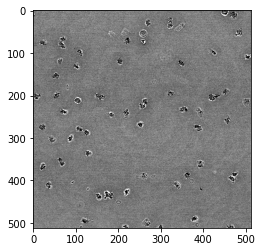

In [12]:
x, y = test_generator.__getitem__(3)
plt.imshow((x[0]* 255).astype(np.uint8))
plt.show()

In [13]:
with strategy.scope():
    
    inputs = Input(shape=(image_size,image_size, 3))
    base_model = EfficientNetB5 (weights = 'imagenet',include_top=False, input_tensor=inputs)

    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(base_model.output)

    x = Dense(1024, kernel_regularizer=l2(0.0003),activation='relu')(x)
    x = Dropout(0.5)(x)

    # and a logistic layer
    predictions = Dense(3, activation="softmax")(x)
    
    model = Model(inputs=inputs, outputs=predictions)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 512, 512, 3)  0           ['normalization[0][0]']      

 block1c_dwconv (DepthwiseConv2  (None, 256, 256, 24  216        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 256, 256, 24  96         ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 256, 256, 24  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 24)          0           ['block1c_activation[0][0]']     
 agePoolin

                                                                                                  
 block2b_bn (BatchNormalization  (None, 128, 128, 24  960        ['block2b_dwconv[0][0]']         
 )                              0)                                                                
                                                                                                  
 block2b_activation (Activation  (None, 128, 128, 24  0          ['block2b_bn[0][0]']             
 )                              0)                                                                
                                                                                                  
 block2b_se_squeeze (GlobalAver  (None, 240)         0           ['block2b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2b_s

 D)                             0)                               ']                               
                                                                                                  
 block2d_bn (BatchNormalization  (None, 128, 128, 24  960        ['block2d_dwconv[0][0]']         
 )                              0)                                                                
                                                                                                  
 block2d_activation (Activation  (None, 128, 128, 24  0          ['block2d_bn[0][0]']             
 )                              0)                                                                
                                                                                                  
 block2d_se_squeeze (GlobalAver  (None, 240)         0           ['block2d_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block3a_dwconv_pad (ZeroPaddin  (None, 131, 131, 24  0          ['block3a_expand_activation[0][0]
 g2D)                           0)                               ']                               
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 64, 64, 240)  6000       ['block3a_dwconv_pad[0][0]']     
 D)                                                                                               
                                                                                                  
 block3a_bn (BatchNormalization  (None, 64, 64, 240)  960        ['block3a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3a_activation (Activation  (None, 64, 64, 240)  0          ['block3a_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3c_se_squeeze (GlobalAver  (None, 384)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3c_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block3c_se_squeeze[0][0]']     
                                                                                                  
 block3c_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block3c_se_reshape[0][0]']     
                                                                                                  
 block3c_se_expand (Conv2D)     (None, 1, 1, 384)    6528        ['block3c_se_reduce[0][0]']      
          

 block3e_se_reshape (Reshape)   (None, 1, 1, 384)    0           ['block3e_se_squeeze[0][0]']     
                                                                                                  
 block3e_se_reduce (Conv2D)     (None, 1, 1, 16)     6160        ['block3e_se_reshape[0][0]']     
                                                                                                  
 block3e_se_expand (Conv2D)     (None, 1, 1, 384)    6528        ['block3e_se_reduce[0][0]']      
                                                                                                  
 block3e_se_excite (Multiply)   (None, 64, 64, 384)  0           ['block3e_activation[0][0]',     
                                                                  'block3e_se_expand[0][0]']      
                                                                                                  
 block3e_project_conv (Conv2D)  (None, 64, 64, 64)   24576       ['block3e_se_excite[0][0]']      
          

                                                                  'block4b_se_expand[0][0]']      
                                                                                                  
 block4b_project_conv (Conv2D)  (None, 32, 32, 128)  98304       ['block4b_se_excite[0][0]']      
                                                                                                  
 block4b_project_bn (BatchNorma  (None, 32, 32, 128)  512        ['block4b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4b_drop (Dropout)         (None, 32, 32, 128)  0           ['block4b_project_bn[0][0]']     
                                                                                                  
 block4b_add (Add)              (None, 32, 32, 128)  0           ['block4b_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block4d_drop (Dropout)         (None, 32, 32, 128)  0           ['block4d_project_bn[0][0]']     
                                                                                                  
 block4d_add (Add)              (None, 32, 32, 128)  0           ['block4d_drop[0][0]',           
                                                                  'block4c_add[0][0]']            
                                                                                                  
 block4e_expand_conv (Conv2D)   (None, 32, 32, 768)  98304       ['block4d_add[0][0]']            
                                                                                                  
 block4e_expand_bn (BatchNormal  (None, 32, 32, 768)  3072       ['block4e_expand_conv[0][0]']    
 ization) 

                                                                  'block4e_add[0][0]']            
                                                                                                  
 block4g_expand_conv (Conv2D)   (None, 32, 32, 768)  98304       ['block4f_add[0][0]']            
                                                                                                  
 block4g_expand_bn (BatchNormal  (None, 32, 32, 768)  3072       ['block4g_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4g_expand_activation (Act  (None, 32, 32, 768)  0          ['block4g_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4g_d

                                                                                                  
 block5b_dwconv (DepthwiseConv2  (None, 32, 32, 1056  26400      ['block5b_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 32, 32, 1056  4224       ['block5b_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5b_activation (Activation  (None, 32, 32, 1056  0          ['block5b_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5b_s

                                                                                                  
 block5d_bn (BatchNormalization  (None, 32, 32, 1056  4224       ['block5d_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5d_activation (Activation  (None, 32, 32, 1056  0          ['block5d_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 1056)        0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_s

                                                                                                  
 block5f_activation (Activation  (None, 32, 32, 1056  0          ['block5f_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5f_se_squeeze (GlobalAver  (None, 1056)        0           ['block5f_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5f_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5f_se_squeeze[0][0]']     
                                                                                                  
 block5f_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5f_se_reshape[0][0]']     
          

                                                                                                  
 block6a_activation (Activation  (None, 16, 16, 1056  0          ['block6a_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1056)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block6a_se_reshape[0][0]']     
          

                                                                                                  
 block6c_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6c_se_reshape[0][0]']     
                                                                                                  
 block6c_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6c_se_reduce[0][0]']      
                                                                                                  
 block6c_se_excite (Multiply)   (None, 16, 16, 1824  0           ['block6c_activation[0][0]',     
                                )                                 'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_p

 block6e_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6e_se_reduce[0][0]']      
                                                                                                  
 block6e_se_excite (Multiply)   (None, 16, 16, 1824  0           ['block6e_activation[0][0]',     
                                )                                 'block6e_se_expand[0][0]']      
                                                                                                  
 block6e_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6e_se_excite[0][0]']      
                                                                                                  
 block6e_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_d

                                )                                 'block6g_se_expand[0][0]']      
                                                                                                  
 block6g_project_conv (Conv2D)  (None, 16, 16, 304)  554496      ['block6g_se_excite[0][0]']      
                                                                                                  
 block6g_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6g_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6g_drop (Dropout)         (None, 16, 16, 304)  0           ['block6g_project_bn[0][0]']     
                                                                                                  
 block6g_add (Add)              (None, 16, 16, 304)  0           ['block6g_drop[0][0]',           
          

                                                                                                  
 block6i_project_bn (BatchNorma  (None, 16, 16, 304)  1216       ['block6i_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6i_drop (Dropout)         (None, 16, 16, 304)  0           ['block6i_project_bn[0][0]']     
                                                                                                  
 block6i_add (Add)              (None, 16, 16, 304)  0           ['block6i_drop[0][0]',           
                                                                  'block6h_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 16, 16, 1824  554496      ['block6i_add[0][0]']            
          

                                                                                                  
 block7c_expand_conv (Conv2D)   (None, 16, 16, 3072  1572864     ['block7b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block7c_expand_bn (BatchNormal  (None, 16, 16, 3072  12288      ['block7c_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block7c_expand_activation (Act  (None, 16, 16, 3072  0          ['block7c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block7c_d

In [15]:
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

stopping = EarlyStopping(monitor='val_loss', patience=5)

callbacks = ModelCheckpoint('eff_full_preprocessed_test_1.h5', 
                            monitor='val_loss', save_best_only=True, mode = 'auto')

In [16]:
history = model.fit(train_generator, 
                              validation_data=valid_generator,
                              epochs = 10,
                              callbacks = [callbacks,lr_schedule,stopping])

Epoch 1/10
312/312 [==============================] - 449s 1s/step - loss: 0.6554 - accuracy: 0.8910 - val_loss: 0.3656 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 2/10
312/312 [==============================] - 416s 1s/step - loss: 0.2506 - accuracy: 0.9736 - val_loss: 0.1614 - val_accuracy: 0.9832 - lr: 0.0010
Epoch 3/10
312/312 [==============================] - 440s 1s/step - loss: 0.2004 - accuracy: 0.9613 - val_loss: 0.1499 - val_accuracy: 0.9728 - lr: 0.0010
Epoch 4/10
312/312 [==============================] - 433s 1s/step - loss: 0.1070 - accuracy: 0.9818 - val_loss: 0.5373 - val_accuracy: 0.9455 - lr: 0.0010
Epoch 5/10
312/312 [==============================] - 442s 1s/step - loss: 0.0748 - accuracy: 0.9852 - val_loss: 0.0247 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 6/10
312/312 [==============================] - 434s 1s/step - loss: 0.0533 - accuracy: 0.9894 - val_loss: 0.0251 - val_accuracy: 0.9976 - lr: 0.0010
Epoch 7/10
312/312 [==============================] - 433s 1s/st

In [17]:
final_model = tf.keras.models.load_model('eff_full_preprocessed_test_1.h5')

In [18]:
predicted = final_model.predict(test_generator, steps = len(test_generator)).argmax(axis=1)

49/49 [==============================] - 13s 217ms/step


In [19]:
test_labels = test['class_label']
test_labels = np.array(test_labels)

In [20]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

([<matplotlib.axis.YTick at 0x7f4f90291310>,
 [Text(0, 0, 'ca'), Text(0, 1, 'cg'), Text(0, 2, 'mock')])

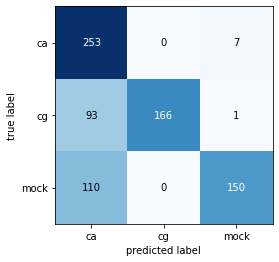

In [21]:
labels = ['ca','cg','mock']

matrix = confusion_matrix (test_labels,predicted)
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(3),labels, fontsize=10)
plt.yticks(range(3),labels, fontsize=10)